# Welcome to Trade-a-gator
### A Signal-aggregated Trading Algo
In this Notebook we: -
- pull in market data (pricing for a specific instrument)
- using a number of indicators based on that data
- train our model
- and using that model, create our own indicator
- we then use that indicator to show how it would have done
Questions to ask
- can our trade-a-gator be used against any pricing data or instruments for only a specific segment

---

### Import Libraries and Dependencies

In [1]:
# Ticker
ticker = 'BTC-USD'#'AAPL'#'TSLA'
#ticker = 'TSLA'#'AAPL'
live = False
colab = False

# Installs
if colab:
    !pip install pandas_datareader
    !pip install hvplot
    !pip install facets-overview

# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas_datareader as data

import hvplot
import hvplot.pandas
from IPython.display import Markdown

#import pandas as ta-lib

#pd.set_option("display.max_rows", 2000)
#pd.set_option("display.max_columns", 2000)
#pd.set_option("display.width", 1000)

### Pandas dataFrame creation
- Read in CSVs, load in data and build up dataframes

In [2]:
# Read and create DFs
# If true, set for Colab, else Jupyter
if colab:
    # Google Colab version
    csv_path_rd = Path(ticker+'_2014-2021.csv')
    csv_path_sv = Path(ticker+'_2014-2021_train.csv')
    csv_path_pred = Path(ticker+'_vertex_preds.csv')
    base_df = pd.read_csv(csv_path_rd)
else:
    # Jupyter Labs version
    csv_path_rd = Path('../Resources/'+ticker+'_2014-2021.csv')
    csv_path_sv = Path('../Resources/'+ticker+'_2014-2021_train.csv')
    csv_path_pred = Path('../vertex_results/'+ticker+'_vertex_preds.csv')

# If live is true, then pull, save and create DF
# Else read and create DF
if live:
    price_df = data.DataReader(ticker, start='2014', end='2022', data_source='yahoo')
    price_df.to_csv(csv_path_rd)
    base_df = price_df
else:
    base_df = pd.read_csv(csv_path_rd)
    # Set index
    base_df.set_index(pd.to_datetime(base_df['Date'], infer_datetime_format=True), inplace=True)
    base_df.drop(columns=['Date'], inplace=True)

base_df.head()

High         Low        Open       Close      Volume  \
Date                                                                     
2014-09-16  468.174011  452.421997  465.864014  457.334015  21056800.0   
2014-09-17  456.859985  413.104004  456.859985  424.440002  34483200.0   
2014-09-18  427.834991  384.532013  424.102997  394.795990  37919700.0   
2014-09-19  423.295990  389.882996  394.673004  408.903992  36863600.0   
2014-09-20  412.425995  393.181000  408.084991  398.821014  26580100.0   

             Adj Close  
Date                    
2014-09-16  457.334015  
2014-09-17  424.440002  
2014-09-18  394.795990  
2014-09-19  408.903992  
2014-09-20  398.821014

### Remove duplicates and N/As, calculate returns

In [3]:
# Drop NAs and calculate mean reversion (24 period)
#base_df['Recent Runup'] = base_df['Close'].dropna().pct_change(24)#.shift(1)

# Drop NAs and calculate daily percent return
base_df['daily_return'] = base_df['Close'].dropna().pct_change()

# Construct dependent variable
base_df['positive_return'] = np.where(base_df['daily_return'] > 0, 1.0, 0.0)

# Calculate VWAP (Volume-Weighted Average Price)
# VWAP = Cumulative Sum of VWAP divided by Cumulative Sum of Volume
base_df['VWAP'] = (# VWAP - Cumulative Sum
                   (((base_df['High'] + base_df['Low'] + base_df['Close'])/3)*base_df['Volume']).cumsum()
                   # Volume Cumulative Sum
                   )/base_df['Volume'].cumsum()

# Average True Range
#base_df['ATR'] = 

# Check it out
base_df.head()

High         Low        Open       Close      Volume  \
Date                                                                     
2014-09-16  468.174011  452.421997  465.864014  457.334015  21056800.0   
2014-09-17  456.859985  413.104004  456.859985  424.440002  34483200.0   
2014-09-18  427.834991  384.532013  424.102997  394.795990  37919700.0   
2014-09-19  423.295990  389.882996  394.673004  408.903992  36863600.0   
2014-09-20  412.425995  393.181000  408.084991  398.821014  26580100.0   

             Adj Close  daily_return  positive_return        VWAP  
Date                                                               
2014-09-16  457.334015           NaN              0.0  459.310008  
2014-09-17  424.440002     -0.071926              0.0  442.023698  
2014-09-18  394.795990     -0.069843              0.0  425.942045  
2014-09-19  408.903992      0.035735              1.0  420.686158  
2014-09-20  398.821014     -0.024659              0.0  417.431877

## Calculate and add indicators
### Starting with the EMA ranges

In [4]:
# Set EMA ranges
ema_window_1 = 1
ema_window_2 = 2
ema_window_3 = 3
ema_window_4 = 4
ema_window_5 = 5
ema_window_6 = 6
ema_window_7 = 7
ema_window_8 = 8
ema_window_10 = 10
ema_window_15 = 15
ema_window_20 = 20
ema_window_24 = 24
ema_window_50 = 50
ema_window_200 = 200

# Construct Exponential Moving Average ranges
base_df['ema_window_1'] = base_df['Close'].ewm(halflife=ema_window_1).mean()
base_df['ema_window_2'] = base_df['Close'].ewm(halflife=ema_window_2).mean()
base_df['ema_window_3'] = base_df['Close'].ewm(halflife=ema_window_3).mean()
base_df['ema_window_4'] = base_df['Close'].ewm(halflife=ema_window_4).mean()
base_df['ema_window_5'] = base_df['Close'].ewm(halflife=ema_window_5).mean()
base_df['ema_window_6'] = base_df['Close'].ewm(halflife=ema_window_6).mean()
base_df['ema_window_7'] = base_df['Close'].ewm(halflife=ema_window_7).mean()
base_df['ema_window_8'] = base_df['Close'].ewm(halflife=ema_window_8).mean()
base_df['ema_window_10'] = base_df['Close'].ewm(halflife=ema_window_10).mean()
base_df['ema_window_15'] = base_df['Close'].ewm(halflife=ema_window_15).mean()
base_df['ema_window_20'] = base_df['Close'].ewm(halflife=ema_window_20).mean()
base_df['ema_window_24'] = base_df['Close'].ewm(halflife=ema_window_24).mean()
base_df['ema_window_50'] = base_df['Close'].ewm(halflife=ema_window_50).mean()
base_df['ema_window_200'] = base_df['Close'].ewm(halflife=ema_window_200).mean()

# Construct a crossover trading signal
#base_df['crossover_long'] = np.where(base_df['fast_close'] > base_df['slow_close'], 1.0, 0.0)
#base_df['crossover_short'] = np.where(base_df['fast_close'] < base_df['slow_close'], -1.0, 0.0)
#base_df['crossover_signal'] = base_df['crossover_long'] + base_df['crossover_short']

base_df.tail()

High           Low          Open         Close  \
Date                                                                 
2021-08-25  49347.582031  46405.781250  49002.640625  46942.218750   
2021-08-26  49112.785156  46394.281250  46894.554688  49058.667969   
2021-08-27  49283.503906  48499.238281  49072.585938  48902.402344   
2021-08-28  49644.113281  47925.855469  48911.250000  48829.832031   
2021-08-30  48870.296875  47785.402344  48716.660156  47785.402344   

                  Volume     Adj Close  daily_return  positive_return  \
Date                                                                    
2021-08-25  3.266655e+10  46942.218750     -0.041228              0.0   
2021-08-26  3.451108e+10  49058.667969      0.045086              1.0   
2021-08-27  2.856810e+10  48902.402344     -0.003185              0.0   
2021-08-28  2.588965e+10  48829.832031     -0.001484              0.0   
2021-08-30  2.823981e+10  47785.402344     -0.021389              0.0   

                    VWAP  ema_window_1  ...  ema_window_5  ema_window_6  \
Date                                    ...                               
2021-08-25  23452.066255  47821.115708  ...  47067.592661  46605.514845   
2021-08-26  23477.448840  48439.891838  ...  47325.336238  46873.156995   
2021-08-27  23499.020624  48671.147091  ...  47529.486557  47094.550264   
2021-08-28  23518.465206  48750.489561  ...  47697.815546  47283.871729   
2021-08-30  23539.093972  48267.945952  ...  47709.153608  47338.589362   

            ema_window_7  ema_window_8  ema_window_10  ema_window_15  \
Date                                                                   
2021-08-25  46126.291771  45649.577992   44753.375513   43068.656768   
2021-08-26  46402.745454  45932.518676   45041.688070   43339.156067   
2021-08-27  46638.403946  46179.007013   45300.228555   43590.383346   
2021-08-28  46845.003756  46399.014771   45536.595541   43826.988445   
2021-08-30  46933.661089  46514.079334   45687.191405   44005.744067   

            ema_window_20  ema_window_24  ema_window_50  ema_window_200  
Date                                                                     
2021-08-25   42157.773090   41808.726859   41279.198866    29462.436067  
2021-08-26   42392.842904   42015.118609   41386.301116    29530.244319  
2021-08-27   42614.582395   42211.186208   41489.777503    29597.277180  
2021-08-28   42826.296615   42399.606206   41590.830203    29663.826942  
2021-08-30   42995.221961   42552.929368   41676.112708    29726.532385  

[5 rows x 23 columns]

### Calculate signals

In [5]:
# Initialise the Signal Column
base_df['EMA Signal 8.20'] = 0.0
base_df['EMA Signal 50.200'] = 0.0
base_df['VWAP Signal'] = 0.0

# Generate the trading signals 0 or 1,
# 0: EMA-8 is below the EMA-20
# 1: EMA-8 is above the EMA-20
base_df['EMA Signal 8.20'] = np.where(
    base_df['ema_window_8'] > base_df['ema_window_20'], 1.0, 0.0
)
# 0: EMA-50 is below the EMA-200
# 1: EMA-50 is above the EMA-200
base_df['EMA Signal 50.200'] = np.where(
    base_df['ema_window_50'] > base_df['ema_window_200'], 1.0, 0.0
)
# 0: EMA-3 is below the VWAP
# 1: EMA-3 is above the VWAP
base_df['VWAP Signal'] = np.where(
    base_df['ema_window_3'] > base_df['VWAP'], 1.0, 0.0
)
# This is Mean Regression ... doesn't work for Crypto
#base_df['RR Signal'] = np.where(
#    base_df['Recent Runup'] < 0, 1.0, 0.0
#)

# Generate the Entry/Exit for later evaluation
base_df['EMA Entry/Exit 8.20'] = base_df['EMA Signal 8.20'].diff()
base_df['EMA Entry/Exit 50.200'] = base_df['EMA Signal 50.200'].diff()
#base_df['RR Entry/Exit'] = base_df['RR Signal'].diff()
base_df['VWAP Entry/Exit'] = base_df['VWAP Signal'].diff()

# Lag the signals
variables_to_lag = ['EMA Entry/Exit 8.20','EMA Entry/Exit 50.200','VWAP Entry/Exit',]
base_df[variables_to_lag] = base_df[variables_to_lag].shift()

In [6]:
# AA DELETE ME
base_df.tail(10)
#base_df[base_df['Signal'] == 1.0]

High           Low          Open         Close  \
Date                                                                 
2021-08-20  49717.019531  48312.199219  49327.074219  48905.492188   
2021-08-21  49471.609375  48199.941406  48869.105469  49321.652344   
2021-08-22  50482.078125  49074.605469  49291.675781  49546.148438   
2021-08-23  49878.769531  47687.117188  49562.347656  47706.117188   
2021-08-24  49202.878906  47163.613281  47727.257812  48960.789062   
2021-08-25  49347.582031  46405.781250  49002.640625  46942.218750   
2021-08-26  49112.785156  46394.281250  46894.554688  49058.667969   
2021-08-27  49283.503906  48499.238281  49072.585938  48902.402344   
2021-08-28  49644.113281  47925.855469  48911.250000  48829.832031   
2021-08-30  48870.296875  47785.402344  48716.660156  47785.402344   

                  Volume     Adj Close  daily_return  positive_return  \
Date                                                                    
2021-08-20  4.058521e+10  48905.492188     -0.008790              0.0   
2021-08-21  2.537098e+10  49321.652344      0.008509              1.0   
2021-08-22  3.430505e+10  49546.148438      0.004552              1.0   
2021-08-23  3.536117e+10  47706.117188     -0.037138              0.0   
2021-08-24  3.264635e+10  48960.789062      0.026300              1.0   
2021-08-25  3.266655e+10  46942.218750     -0.041228              0.0   
2021-08-26  3.451108e+10  49058.667969      0.045086              1.0   
2021-08-27  2.856810e+10  48902.402344     -0.003185              0.0   
2021-08-28  2.588965e+10  48829.832031     -0.001484              0.0   
2021-08-30  2.823981e+10  47785.402344     -0.021389              0.0   

                    VWAP  ema_window_1  ...  ema_window_20  ema_window_24  \
Date                                    ...                                 
2021-08-20  23331.389589  48275.472177  ...   40965.689004   40774.748586   
2021-08-21  23350.849202  48798.562260  ...   41250.323791   41018.062346   
2021-08-22  23377.834568  49172.355349  ...   41532.910033   41260.840402   
2021-08-23  23404.246349  48439.236268  ...   41743.192131   41444.324921   
2021-08-24  23428.598907  48700.012665  ...   41989.049979   41658.304065   
2021-08-25  23452.066255  47821.115708  ...   42157.773090   41808.726859   
2021-08-26  23477.448840  48439.891838  ...   42392.842904   42015.118609   
2021-08-27  23499.020624  48671.147091  ...   42614.582395   42211.186208   
2021-08-28  23518.465206  48750.489561  ...   42826.296615   42399.606206   
2021-08-30  23539.093972  48267.945952  ...   42995.221961   42552.929368   

            ema_window_50  ema_window_200  EMA Signal 8.20  EMA Signal 50.200  \
Date                                                                            
2021-08-20   40762.333522    29129.758455              1.0                1.0   
2021-08-21   40880.172193    29199.628048              1.0                1.0   
2021-08-22   40999.479249    29270.032652              1.0                1.0   
2021-08-23   41091.811515    29333.826585              1.0                1.0   
2021-08-24   41200.146054    29401.741247              1.0                1.0   
2021-08-25   41279.198866    29462.436067              1.0                1.0   
2021-08-26   41386.301116    29530.244319              1.0                1.0   
2021-08-27   41489.777503    29597.277180              1.0                1.0   
2021-08-28   41590.830203    29663.826942              1.0                1.0   
2021-08-30   41676.112708    29726.532385              1.0                1.0   

            VWAP Signal  EMA Entry/Exit 8.20  EMA Entry/Exit 50.200  \
Date                                                                  
2021-08-20          1.0                  0.0                    0.0   
2021-08-21          1.0                  0.0                    0.0   
2021-08-22          1.0                  0.0                    0.0   
2021-08-23          1.0                  0.0     

### Plot the ranges

In [7]:
import hvplot.pandas

# Visualize EXIT position relative to close price
ema_exit_1 = base_df[base_df['EMA Entry/Exit 8.20'] == -1.0]['Close'].hvplot.scatter(
    color='red', marker='v', size=100, legend=False, ylabel='Price in $', width=1000, height=400
)
ema_exit_2 = base_df[base_df['EMA Entry/Exit 50.200'] == -1.0]['Close'].hvplot.scatter(
    color='red', marker='v', size=100, legend=False, ylabel='Price in $', width=1000, height=400
)
vwap_exit = base_df[base_df['VWAP Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='blue', marker='v', legend=False, ylabel='Price in $', width=1000, height=400
)
# This is Mean Regression ... doesn't really work for Crypto
#rr_exit = base_df[base_df['RR Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
#    color='blue', marker='v', legend=False, ylabel='Price in $', width=1000, height=400
#)


# Visualize ENTRY position relative to close price
ema_entry_1 = base_df[base_df['EMA Entry/Exit 8.20'] == 1.0]['Close'].hvplot.scatter(
    color='green', marker='^', size=100, legend=False, ylabel='Price in $', width=1000, height=400
)
ema_entry_2 = base_df[base_df['EMA Entry/Exit 50.200'] == 1.0]['Close'].hvplot.scatter(
    color='green', marker='^', size=100, legend=False, ylabel='Price in $', width=1000, height=400
)
vwap_entry = base_df[base_df['VWAP Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='blue', marker='^', legend=False, ylabel='Price in $', width=1000, height=400
)
# This is Mean Regression ... doesn't work for Crypto
#rr_entry = base_df[base_df['RR Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
#    color='blue', marker='^', legend=False, ylabel='Price in $', width=1000, height=400
#)


# Visualize close price for the investment
instrument_close = base_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = base_df[['ema_window_1', 'ema_window_2', 'ema_window_3', 'ema_window_4',
                       'ema_window_5', 'ema_window_6', 'ema_window_7', 'ema_window_8',
                       'ema_window_10', 'ema_window_15', 'ema_window_24', 'ema_window_50', 'ema_window_200'
                      ]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)
moving_avg_10_20 = base_df[['ema_window_8', 'ema_window_20']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)
moving_avg_50_200 = base_df[['ema_window_50', 'ema_window_200']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize VWAP
vwap = base_df[['VWAP']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
#entry_exit_plot = instrument_close * moving_avgs * ema_entry * rr_entry * ema_exit * rr_exit
#entry_exit_plot = instrument_close * moving_avgs * rr_entry * rr_exit
#entry_exit_plot = instrument_close * moving_avgs * ema_entry * ema_exit
#entry_exit_plot = instrument_close * moving_avg_10_20 * vwap * vwap_entry * vwap_exit
#entry_exit_plot = instrument_close * vwap * vwap_entry * vwap_exit
#                    * moving_avgs * ema_entry_1 * ema_exit_1 * ema_entry_2 * ema_exit_2
entry_exit_plot = (instrument_close *
                   #moving_avg_10_20  * ema_entry_1 * ema_exit_1 *
                   #moving_avg_50_200 * ema_entry_2 * ema_exit_2 *
                   vwap * vwap_entry * vwap_exit
                  )
#entry_exit_plot.opts(xaxis=None)
# With X
entry_exit_plot.opts(yformatter="%.0f")

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Curve.II         :Curve   [Date]   (VWAP)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

<AxesSubplot:xlabel='Date'>

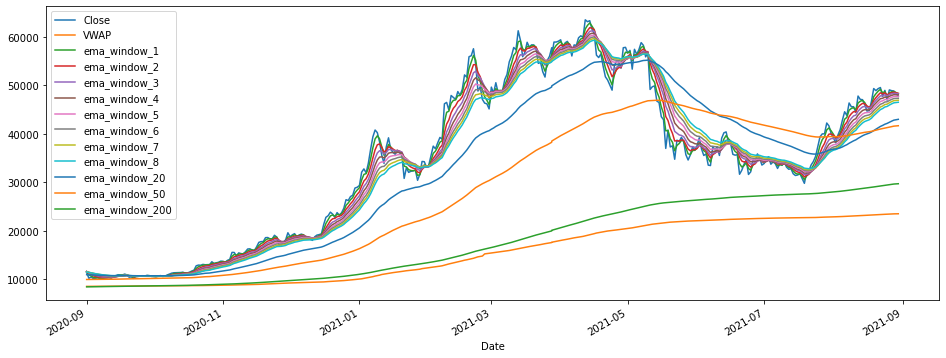

In [8]:
# Plot the EMA ranges
# American Date Format
base_df['09-01-20':][['Close','VWAP',
                      'ema_window_1', 'ema_window_2', 'ema_window_3',  'ema_window_4',
                      'ema_window_5', 'ema_window_6', 'ema_window_7', 'ema_window_8',
                      'ema_window_20', 'ema_window_50', 'ema_window_200'
                     ]].plot(figsize=(16,6))

<AxesSubplot:xlabel='Date'>

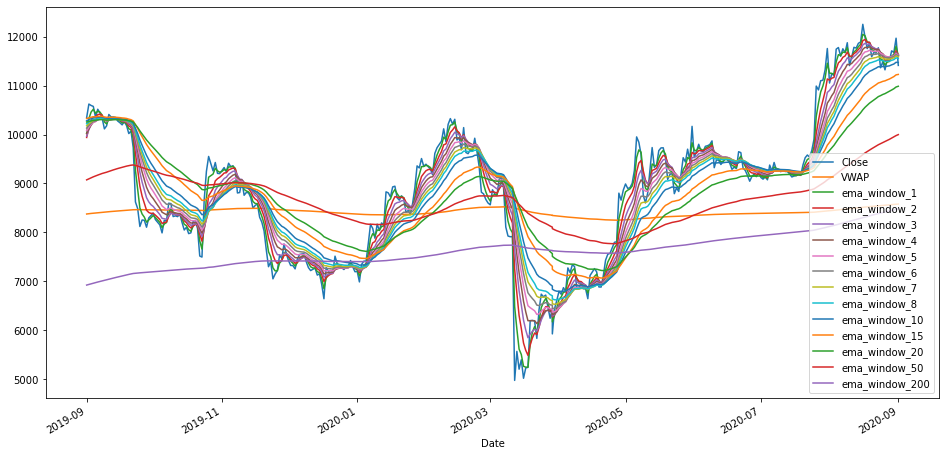

In [9]:
base_df['09-01-19':'09-01-20'][['Close','VWAP',
                                'ema_window_1', 'ema_window_2', 'ema_window_3',  'ema_window_4',
                                'ema_window_5', 'ema_window_6', 'ema_window_7', 'ema_window_8',
                                'ema_window_10', 'ema_window_15', 'ema_window_20', 'ema_window_50','ema_window_200'
                               ]].plot(figsize=(16,8))
# Possibles ... ichi moku (20, 60, 120, 30) ... stochastic () ... rsi () ... hash-rate (BTC)

<AxesSubplot:xlabel='Date'>

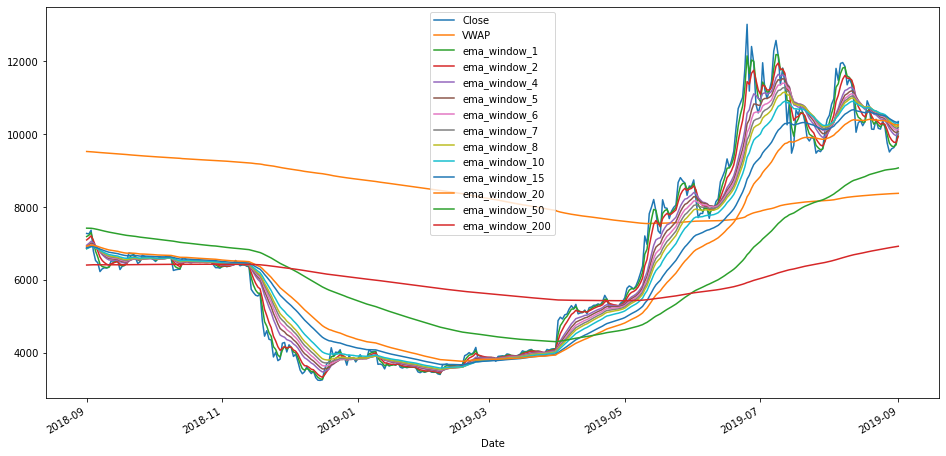

In [10]:
base_df['09-01-18':'09-01-19'][['Close','VWAP',
                                'ema_window_1', 'ema_window_2', 'ema_window_4',
                                'ema_window_5', 'ema_window_6', 'ema_window_7', 'ema_window_8',
                                'ema_window_10', 'ema_window_15', 'ema_window_20', 'ema_window_50', 'ema_window_200'
                               ]].plot(figsize=(16,8))

In [11]:
# Quick datareader test
#from pandas_datareader import data
#goog = data.DataReader('GOOG', start='2020', end='2021', data_source='yahoo')
#goog.tail()
#goog['01-09-20':'14-09-20']
base_df.tail()

High           Low          Open         Close  \
Date                                                                 
2021-08-25  49347.582031  46405.781250  49002.640625  46942.218750   
2021-08-26  49112.785156  46394.281250  46894.554688  49058.667969   
2021-08-27  49283.503906  48499.238281  49072.585938  48902.402344   
2021-08-28  49644.113281  47925.855469  48911.250000  48829.832031   
2021-08-30  48870.296875  47785.402344  48716.660156  47785.402344   

                  Volume     Adj Close  daily_return  positive_return  \
Date                                                                    
2021-08-25  3.266655e+10  46942.218750     -0.041228              0.0   
2021-08-26  3.451108e+10  49058.667969      0.045086              1.0   
2021-08-27  2.856810e+10  48902.402344     -0.003185              0.0   
2021-08-28  2.588965e+10  48829.832031     -0.001484              0.0   
2021-08-30  2.823981e+10  47785.402344     -0.021389              0.0   

                    VWAP  ema_window_1  ...  ema_window_20  ema_window_24  \
Date                                    ...                                 
2021-08-25  23452.066255  47821.115708  ...   42157.773090   41808.726859   
2021-08-26  23477.448840  48439.891838  ...   42392.842904   42015.118609   
2021-08-27  23499.020624  48671.147091  ...   42614.582395   42211.186208   
2021-08-28  23518.465206  48750.489561  ...   42826.296615   42399.606206   
2021-08-30  23539.093972  48267.945952  ...   42995.221961   42552.929368   

            ema_window_50  ema_window_200  EMA Signal 8.20  EMA Signal 50.200  \
Date                                                                            
2021-08-25   41279.198866    29462.436067              1.0                1.0   
2021-08-26   41386.301116    29530.244319              1.0                1.0   
2021-08-27   41489.777503    29597.277180              1.0                1.0   
2021-08-28   41590.830203    29663.826942              1.0                1.0   
2021-08-30   41676.112708    29726.532385              1.0                1.0   

            VWAP Signal  EMA Entry/Exit 8.20  EMA Entry/Exit 50.200  \
Date                                                                  
2021-08-25          1.0                  0.0                    0.0   
2021-08-26          1.0                  0.0                    0.0   
2021-08-27          1.0                  0.0                    0.0   
2021-08-28          1.0                  0.0                    0.0   
2021-08-30          1.0                  0.0                    0.0   

            VWAP Entry/Exit  
Date                         
2021-08-25              0.0  
2021-08-26              0.0  
2021-08-27              0.0  
2021-08-28              0.0  
2021-08-30              0.0  

[5 rows x 29 columns]

In [12]:
# Set x variable list of features
x_var_list = ['EMA Signal 8.20','EMA Signal 50.200', 'VWAP Signal']

# Filter by x-variable list
base_df[x_var_list].tail()

EMA Signal 8.20  EMA Signal 50.200  VWAP Signal
Date                                                       
2021-08-25              1.0                1.0          1.0
2021-08-26              1.0                1.0          1.0
2021-08-27              1.0                1.0          1.0
2021-08-28              1.0                1.0          1.0
2021-08-30              1.0                1.0          1.0

In [13]:
# Drop NAs and replace positive/negative infinity values
base_df.dropna(subset=x_var_list, inplace=True)
base_df.dropna(subset=['daily_return'], inplace=True)
base_df = base_df.replace([np.inf, -np.inf], np.nan)
base_df.head()

# Create new dataframe and rename columns for further analysis
new_cols = {'VWAP Entry/Exit':'vwap_entry_exit','Adj Close':'adj_close','VWAP Signal':'vwap_signal',
            'EMA Entry/Exit 8.20':'ema_entry_exit_8_20','EMA Entry/Exit 50.200':'ema_entry_exit_50_200',
            'EMA Signal 8.20':'ema_signal_8_20','EMA Signal 50.200':'ema_signal_50_200','Date':'date',
            'High':'high','Low':'low','Open':'open','Close':'close','VWAP':'vwap','Volume':'volume'}
vertex_ai_df = base_df.reset_index()
vertex_ai_df.rename(columns=new_cols, inplace=True)
vertex_ai_df = vertex_ai_df[1:-1]
# Write to CSV
vertex_ai_df.to_csv(csv_path_sv,index_label='rownum')
vertex_ai_df.head()

date        high         low        open       close      volume  \
1 2014-09-18  427.834991  384.532013  424.102997  394.795990  37919700.0   
2 2014-09-19  423.295990  389.882996  394.673004  408.903992  36863600.0   
3 2014-09-20  412.425995  393.181000  408.084991  398.821014  26580100.0   
4 2014-09-21  406.915985  397.130005  399.100006  402.152008  24127600.0   
5 2014-09-22  441.557007  396.196991  402.092010  435.790985  45099500.0   

    adj_close  daily_return  positive_return        vwap  ...  ema_window_20  \
1  394.795990     -0.069843              0.0  425.942045  ...     424.801230   
2  408.903992      0.035735              1.0  420.686158  ...     420.617988   
3  398.821014     -0.024659              0.0  417.431877  ...     415.951312   
4  402.152008      0.008352              1.0  415.383931  ...     413.447658   
5  435.790985      0.083647              1.0  417.205031  ...     416.980804   

   ema_window_24  ema_window_50  ema_window_200  ema_signal_8_20  \
1     424.921514     425.234393      425.451091              0.0   
2     420.742023     421.066509      421.292786              0.0   
3     416.100995     416.493208      416.767225              0.0   
4     413.605133     414.019411      414.310202              0.0   
5     417.055638     417.260468      417.410883              0.0   

   ema_signal_50_200  vwap_signal  ema_entry_exit_8_20  ema_entry_exit_50_200  \
1                0.0          0.0                  0.0                    0.0   
2                0.0          0.0                  0.0                    0.0   
3                0.0          0.0                  0.0                    0.0   
4                0.0          0.0                  0.0                    0.0   
5                0.0          0.0                  0.0                    0.0   

   vwap_entry_exit  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
5              0.0  

[5 rows x 30 columns]

In [14]:
# Create DF for forecasting
#pred_ai_df = pd.date_range(list(vertex_ai_df['date'])[-1], periods=90, freq='1d'
#                              ).to_frame().reset_index().drop(columns=0).rename(columns={"index":"date"})
pred_split = round(((base_df.count()[0:1])[0])*0.98)
pred_ai_df = vertex_ai_df[pred_split:-1]
pred_ai_df.drop(columns="positive_return", inplace=True)
pred_ai_df["positive_return"] = ""

if colab:
    pred_ai_df.to_csv(ticker+'_pred.csv',index_label='rownum')
else:
    pred_ai_df.to_csv('../Resources/'+ticker+'_pred.csv',index_label='rownum')

pred_ai_df.tail()

date          high           low          open         close  \
2528 2021-08-23  49878.769531  47687.117188  49562.347656  47706.117188   
2529 2021-08-24  49202.878906  47163.613281  47727.257812  48960.789062   
2530 2021-08-25  49347.582031  46405.781250  49002.640625  46942.218750   
2531 2021-08-26  49112.785156  46394.281250  46894.554688  49058.667969   
2532 2021-08-27  49283.503906  48499.238281  49072.585938  48902.402344   

            volume     adj_close  daily_return          vwap  ema_window_1  \
2528  3.536117e+10  47706.117188     -0.037138  23404.246349  48439.236268   
2529  3.264635e+10  48960.789062      0.026300  23428.598907  48700.012665   
2530  3.266655e+10  46942.218750     -0.041228  23452.066255  47821.115708   
2531  3.451108e+10  49058.667969      0.045086  23477.448840  48439.891838   
2532  2.856810e+10  48902.402344     -0.003185  23499.020624  48671.147091   

      ...  ema_window_24  ema_window_50  ema_window_200  ema_signal_8_20  \
2528  ...   41444.324921   41091.811515    29333.826585              1.0   
2529  ...   41658.304065   41200.146054    29401.741247              1.0   
2530  ...   41808.726859   41279.198866    29462.436067              1.0   
2531  ...   42015.118609   41386.301116    29530.244319              1.0   
2532  ...   42211.186208   41489.777503    29597.277180              1.0   

      ema_signal_50_200  vwap_signal  ema_entry_exit_8_20  \
2528                1.0          1.0                  0.0   
2529                1.0          1.0                  0.0   
2530                1.0          1.0                  0.0   
2531                1.0          1.0                  0.0   
2532                1.0          1.0                  0.0   

      ema_entry_exit_50_200  vwap_entry_exit  positive_return  
2528                    0.0              0.0                   
2529                    0.0              0.0                   
2530                    0.0              0.0                   
2531                    0.0              0.0                   
2532                    0.0              0.0                   

[5 rows x 30 columns]

In [15]:
# For Visualisation, create full Dataframe Sets for Train and Test
# Determine the split
tt_pct = 0.75
tt_tot = (base_df.count()[0:1])[0]
tt_split = round(tt_tot*tt_pct)

# Create DFs
base_train = base_df[0:tt_split]
base_test = base_df[tt_split:-1]

In [16]:
# Install the facets_overview pip package.
#!pip install facets-overview

# Display the Dive visualization for the training data.
from IPython.core.display import display, HTML

jsonstr = base_train.to_json(orient='records')
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))


In [17]:
# Create the feature stats for the datasets and stringify it.
import base64
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': base_train},
                                  {'name': 'test', 'table': base_test}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

# Display the facets overview visualization for this data
from IPython.core.display import display, HTML

HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html2 = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html2))

In [18]:
# Construct dependent variable
# AA DELETE ?? ... already above
#base_df['positive_return'] = np.where(base_df['daily_return'] > 0, 1.0, 0.0)
base_df[['positive_return','daily_return']].sample(7)

positive_return  daily_return
Date                                     
2018-02-25              0.0     -0.015117
2016-11-09              1.0      0.018912
2015-06-15              1.0      0.059420
2020-04-01              1.0      0.028281
2019-12-14              0.0     -0.019947
2019-11-23              1.0      0.013872
2019-06-08              0.0     -0.033448

In [19]:
# Determine Split
#tt_split = round(((base_df.count()[0:1])[0])*.7)

# DELETE AA
# Construct training start and end dates
#training_start = base_df.index.min().strftime(format= '%Y-%m-%d')
#training_end = '2019-09-14'

# Construct testing start and end dates
#testing_start =  '2019-09-15'
#testing_end = base_df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
#print(f"Training Start: {training_start}")
#print(f"Training End: {training_end}")
#print(f"Testing Start: {testing_start}")
#print(f"Testing End: {testing_end}")

In [20]:
# Using previous Split ...
# Construct the x train and y train datasets
X_train = base_df[x_var_list][0:tt_split]
y_train = base_df['positive_return'][0:tt_split]

# Construct the x test and y test datasets
X_test = base_df[x_var_list][tt_split:-1]
y_test = base_df['positive_return'][tt_split:-1]

X_train.tail()

EMA Signal 8.20  EMA Signal 50.200  VWAP Signal
Date                                                       
2019-11-27              0.0                1.0          0.0
2019-11-28              0.0                1.0          0.0
2019-11-29              0.0                1.0          0.0
2019-11-30              0.0                1.0          0.0
2019-12-01              0.0                1.0          0.0

In [21]:
y_train.head()

Date
2014-09-17    0.0
2014-09-18    0.0
2014-09-19    1.0
2014-09-20    0.0
2014-09-21    1.0
Name: positive_return, dtype: float64

In [22]:
X_test.tail()

EMA Signal 8.20  EMA Signal 50.200  VWAP Signal
Date                                                       
2021-08-24              1.0                1.0          1.0
2021-08-25              1.0                1.0          1.0
2021-08-26              1.0                1.0          1.0
2021-08-27              1.0                1.0          1.0
2021-08-28              1.0                1.0          1.0

In [23]:
y_test.head()

Date
2019-12-02    0.0
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    1.0
2019-12-06    1.0
Name: positive_return, dtype: float64

In [24]:
# Import SKLearn Ensemble Model
from sklearn.ensemble import RandomForestClassifier

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=50000, max_depth=10, random_state=10)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the x test dataset
predictions = model.predict(X_test)

In [25]:
# Assemble ACTUAL y data (Y_test) with RF predicted y data
# (from just above) into two columns in a dataframe:
results = y_test.to_frame()
results["ml_prediction"] = predictions
results["return"] = base_df["daily_return"][tt_split:-1]

## AA DELETE
#ticker = 'BTC-USD'
#ticker = 'TSLA'#'BTC-USD'

if ticker == 'BTC-USD':
    # If BTC/USD then add the results from VERTEX AI (Google's AutoML)
    # Read in the csv, drop all except predicted value
    vertex = True
    csv_path_pred = Path('../vertex_results/'+ticker+'_vertex_preds.csv')
    vtx_pred_df = pd.read_csv(csv_path_pred)
    vtx_pred_df.set_index(pd.to_datetime(vtx_pred_df['date'], infer_datetime_format=True), inplace=True)
    vtx_pred_df.sort_index(inplace=True)
    # Drop all and leave prediction
    vtx_pred_df = vtx_pred_df["predicted_positive_return"].to_frame()

    # Add VERTEX predicted value to results DF
    all_results = results[((results.count()[0:1])[0])-((vtx_pred_df.count()[0:1])[0])-1:-1]
    all_results["vertex_actual_prediction"] = vtx_pred_df["predicted_positive_return"]
    # Predicted results need to be transformed to 1 or 0
    all_results["vertex_prediction"] = np.where(all_results["vertex_actual_prediction"] > 0.5, 1.0, 0.0)
    results = all_results

# Have a squiz
results.head(10)

positive_return  ml_prediction    return  \
Date                                                   
2021-07-11              0.0            1.0 -0.031669   
2021-07-12              0.0            1.0 -0.013688   
2021-07-13              1.0            1.0  0.003679   
2021-07-14              0.0            1.0 -0.031735   
2021-07-15              0.0            1.0 -0.011302   
2021-07-16              1.0            1.0  0.003549   
2021-07-17              1.0            1.0  0.008364   
2021-07-18              0.0            1.0 -0.030789   
2021-07-19              0.0            1.0 -0.032789   
2021-07-20              1.0            1.0  0.077274   

            vertex_actual_prediction  vertex_prediction  
Date                                                     
2021-07-11                  0.050801                0.0  
2021-07-12                  0.051312                0.0  
2021-07-13                  0.950894                1.0  
2021-07-14                  0.051115                0.0  
2021-07-15                  0.051697                0.0  
2021-07-16                  0.951394                1.0  
2021-07-17                  0.951263                1.0  
2021-07-18                  0.051045                0.0  
2021-07-19                  0.051241                0.0  
2021-07-20                  0.951787                1.0

In [26]:
# DELETE LATER AA
#results.tail()
#vtx_pred_df.count()
#all_results.count()
#round(((base_df.count()[0:1])[0])*0.98)
#((results.count()[0:1])[0])-((vtx_pred_df.count()[0:1])[0])

## Quickly Vizualize results

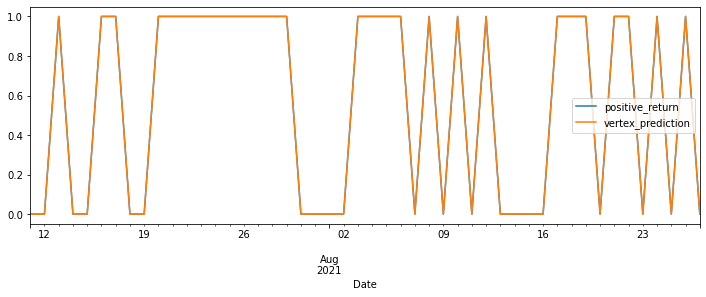

In [27]:
if vertex:
    results[['positive_return', 'vertex_prediction']].plot(figsize=(12,4))
else:
    results[['positive_return', 'ml_prediction']].plot(figsize=(12,4))

## Use Facet to visualize results

In [28]:
# Visualise the results with Facet
gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'results', 'table': results}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html3 = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html3))

In [29]:
# Replace predicted values 0 to -1 to account for shorting
#results["predicted_value"].replace(0, -1, inplace=True)
#results_shorts = results
#results_shorts["predicted_value"].replace(0, -1, inplace=True)

# test  AA DELETE ME LATER
#results['Predicted Value'].replace(1, 0, inplace=True)
#results_shorts.sample(10)

In [30]:
# Calculate cumulative return of model and plot the result
# Don't use Matplotlib
matplotlib = False
if matplotlib:
    (1 + (results['return'] * results['ml_prediction']
         )).cumprod().plot(title="Cumulative Returns for " + ticker +
                                 " Using Positive Return Prediction (Long Positions)\n",figsize=(14,7))

# Calculate vals for HvPlot; if BTC, load Google Vertex results
# Actual
results['actual_cum_ret'] = (1 + (results['return'] * results['positive_return'])).cumprod()

# This ML return
results['ml_pred_cum_ret'] = (1 + (results['return'] * results['ml_prediction'])).cumprod()

if vertex:
    # Vertex return
    results['vtx_pred_cum_ret'] = (1 + (results['return'] * results['vertex_prediction'])).cumprod()

results.head(2)

positive_return  ml_prediction    return  \
Date                                                   
2021-07-11              0.0            1.0 -0.031669   
2021-07-12              0.0            1.0 -0.013688   

            vertex_actual_prediction  vertex_prediction  actual_cum_ret  \
Date                                                                      
2021-07-11                  0.050801                0.0             1.0   
2021-07-12                  0.051312                0.0             1.0   

            ml_pred_cum_ret  vtx_pred_cum_ret  
Date                                           
2021-07-11         0.968331               1.0  
2021-07-12         0.955077               1.0

In [43]:
# Plot results based on predictions
# Set up plots for Random Forests first
prediction = results[['ml_pred_cum_ret','actual_cum_ret']].hvplot(
    title="Cumulative Returns for " + ticker + " Using Positive Return Predictions\n",
    ylabel='Nx Return', width=800, height=400)
plot_predictions = (prediction)

if vertex:
    # If Vertex data exists, add to plot
    prediction_vtx = results[['ml_pred_cum_ret','vtx_pred_cum_ret','actual_cum_ret']].hvplot(
        ylabel='Nx Return',
        width=800, height=400)
    plot_predictions = (prediction * prediction_vtx)

plot_predictions

:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [Date]   (value)

---
## Portfolio Tracking
Here we build up a backtested portfolio based on the chosen stock

In [32]:
base_df.tail()
vertex

True

In [33]:
# Signal tracked
#signal = "EMA Signal 8.20"
#entry_exit = "EMA Entry/Exit 8.20"
#signal = "EMA Signal 50.200"
#entry_exit = "EMA Entry/Exit 50.200"
signal = "VWAP Signal"
entry_exit = "VWAP Entry/Exit"

# Set initial capital
initial_capital = float(100000)

# Set the share size
share_size = 200

# Take a 500 share position where the VWAP is 1
base_df['Position'] = share_size * base_df[signal]

# Find the points in time where a 500 share position is bought or sold
base_df['Entry/Exit Position'] = base_df['Position'].diff()

# Multiply share price by entry/exit positions and get the cumulative sum
base_df['Portfolio Holdings'] = base_df['Close'] * base_df['Entry/Exit Position'].cumsum()

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
base_df['Portfolio Cash'] = initial_capital - (base_df['Close'] * base_df['Entry/Exit Position']).cumsum()

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
base_df['Portfolio Total'] = base_df['Portfolio Cash'] + base_df['Portfolio Holdings']

# Calculate the portfolio daily returns
base_df['Portfolio Daily Returns'] = base_df['Portfolio Total'].pct_change()

# Calculate the cumulative returns
base_df['Portfolio Cumulative Returns'] = (1 + base_df['Portfolio Daily Returns']).cumprod() - 1

# Print the DataFrame
base_df.tail(10)

High           Low          Open         Close  \
Date                                                                 
2021-08-20  49717.019531  48312.199219  49327.074219  48905.492188   
2021-08-21  49471.609375  48199.941406  48869.105469  49321.652344   
2021-08-22  50482.078125  49074.605469  49291.675781  49546.148438   
2021-08-23  49878.769531  47687.117188  49562.347656  47706.117188   
2021-08-24  49202.878906  47163.613281  47727.257812  48960.789062   
2021-08-25  49347.582031  46405.781250  49002.640625  46942.218750   
2021-08-26  49112.785156  46394.281250  46894.554688  49058.667969   
2021-08-27  49283.503906  48499.238281  49072.585938  48902.402344   
2021-08-28  49644.113281  47925.855469  48911.250000  48829.832031   
2021-08-30  48870.296875  47785.402344  48716.660156  47785.402344   

                  Volume     Adj Close  daily_return  positive_return  \
Date                                                                    
2021-08-20  4.058521e+10  48905.492188     -0.008790              0.0   
2021-08-21  2.537098e+10  49321.652344      0.008509              1.0   
2021-08-22  3.430505e+10  49546.148438      0.004552              1.0   
2021-08-23  3.536117e+10  47706.117188     -0.037138              0.0   
2021-08-24  3.264635e+10  48960.789062      0.026300              1.0   
2021-08-25  3.266655e+10  46942.218750     -0.041228              0.0   
2021-08-26  3.451108e+10  49058.667969      0.045086              1.0   
2021-08-27  2.856810e+10  48902.402344     -0.003185              0.0   
2021-08-28  2.588965e+10  48829.832031     -0.001484              0.0   
2021-08-30  2.823981e+10  47785.402344     -0.021389              0.0   

                    VWAP  ema_window_1  ...  EMA Entry/Exit 8.20  \
Date                                    ...                        
2021-08-20  23331.389589  48275.472177  ...                  0.0   
2021-08-21  23350.849202  48798.562260  ...                  0.0   
2021-08-22  23377.834568  49172.355349  ...                  0.0   
2021-08-23  23404.246349  48439.236268  ...                  0.0   
2021-08-24  23428.598907  48700.012665  ...                  0.0   
2021-08-25  23452.066255  47821.115708  ...                  0.0   
2021-08-26  23477.448840  48439.891838  ...                  0.0   
2021-08-27  23499.020624  48671.147091  ...                  0.0   
2021-08-28  23518.465206  48750.489561  ...                  0.0   
2021-08-30  23539.093972  48267.945952  ...                  0.0   

            EMA Entry/Exit 50.200  VWAP Entry/Exit  Position  \
Date                                                           
2021-08-20                    0.0              0.0     200.0   
2021-08-21                    0.0              0.0     200.0   
2021-08-22                    0.0              0.0     200.0   
2021-08-23                    0.0              0.0     200.0   
2021-08-24                    0.0              0.0     200.0   
2021-08-25                    0.0              0.0     200.0   
2021-08-26                    0.0              0.0     200.0   
2021-08-27                    0.0              0.0     200.0   
2021-08-28                    0.0              0.0     200.0   
2021-08-30                    0.0              0.0     200.0   

            Entry/Exit Position  Portfolio Holdings  Portfolio Cash  \
Date                                                                  
2021-08-20                  0.0        9.781098e+06  -710117.059326   
2021-08-21                  0.0        9.864330e+06  -710117.059326   
2021-08-22                  0.0        9.909230e+06  -710117.059326   
2021-08-23                  0.0        9.541223e+06  -710117.059326   
2021-08-24                  0.0        9.792158e+06  -710117.059326   
2021-08-25                  0.0        9.388444e+06  -710117.059326   
2021-08-26                  0.0        9.811734e+06  -710117.059326   
2021-08-27                  0.0        9.780480e+06  -710117.059326   
2021-0

## Plot Entry/Exits for Portfolio based on Trades

In [34]:
# Visualize exit position relative to total portfolio value
exit = base_df[base_df[entry_exit] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = base_df[base_df[entry_exit] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize total portoflio value for the investment
total_portfolio_value = base_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Overlay plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(yformatter="%.0f", xaxis=None)

:Overlay
   .Curve.I                    :Curve   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Date]   (Portfolio Total)

# OLIVER AREA

# BRIAN AREA

# CHUCK AREA